<a href="https://colab.research.google.com/github/dhruv716/Nemesis/blob/main/Nemesis_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch datetime unsloth gradio transformers -U bitsandbytes accelerate trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 

In [ ]:
# Import required libraries
from unsloth import FastLanguageModel
import torch
import os
import json
from datetime import datetime
from google.colab import drive
import gradio as gr

# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)

# Define paths
MODEL_PATH = '/content/drive/MyDrive/legal_model'
SESSIONS_DIR = '/content/drive/MyDrive/legal_sessions'

# Ensure sessions directory exists
os.makedirs(SESSIONS_DIR, exist_ok=True)

# Load the fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_PATH,
    max_seq_length=2048,  # Increased context window for better memory handling
    dtype=torch.float16,
    load_in_4bit=True
)

# Memory Management Classes
class LegalMemory:
    def __init__(self, max_history_length=15):
        self.conversation_history = []
        self.max_history_length = max_history_length
        self.legal_elements = {
            "key_arguments": [],           # Main arguments made
            "cited_sections": set(),       # Legal sections cited
            "cited_precedents": set(),     # Legal cases cited
            "disputed_points": [],         # Points of contention
            "admitted_facts": []           # Facts agreed upon
        }

    def add_exchange(self, user_input, model_response):
        """Add a conversation exchange to memory and extract legal elements"""
        self.conversation_history.append({"user": user_input, "assistant": model_response})

        # Trim history if needed
        if len(self.conversation_history) > self.max_history_length:
            self.conversation_history = self.conversation_history[-self.max_history_length:]

        # Extract legal elements from response
        self._extract_legal_elements(model_response)

    def _extract_legal_elements(self, text):
        """Extract important legal elements from text using regex patterns"""
        import re

        # Extract section citations (e.g., "Section 123 of Indian Penal Code")
        section_pattern = r"[Ss]ection\s+(\d+(?:\([a-z]\))?)\s+of\s+([A-Za-z\s]+)(?:Act|Code)"
        sections = re.findall(section_pattern, text)
        for section, code in sections:
            self.legal_elements["cited_sections"].add(f"Section {section} of {code.strip()}")

        # Extract case citations (e.g., "in State of Punjab v. XYZ (2010)")
        case_pattern = r"([A-Za-z\s]+)\s+v\.\s+([A-Za-z\s]+)\s+\((\d{4})\)"
        cases = re.findall(case_pattern, text)
        for plaintiff, defendant, year in cases:
            self.legal_elements["cited_precedents"].add(f"{plaintiff.strip()} v. {defendant.strip()} ({year})")

    def get_formatted_history(self):
        """Get formatted conversation history for prompt context"""
        formatted_history = ""
        for exchange in self.conversation_history:
            formatted_history += f"Human: {exchange['user']}\nAssistant: {exchange['assistant']}\n\n"
        return formatted_history

    def get_legal_context(self):
        """Get structured legal context to enhance prompts"""
        if not any(self.legal_elements.values()):
            return ""

        context = "\n### Legal Context\n"

        if self.legal_elements["cited_sections"]:
            context += "Previously cited provisions: " + ", ".join(list(self.legal_elements["cited_sections"])[:5]) + "\n"

        if self.legal_elements["cited_precedents"]:
            context += "Case precedents: " + ", ".join(list(self.legal_elements["cited_precedents"])[:3]) + "\n"

        if self.legal_elements["key_arguments"]:
            context += "Key arguments: " + "; ".join(self.legal_elements["key_arguments"][-3:]) + "\n"

        return context

class SessionManager:
    def __init__(self, sessions_dir):
        self.sessions_dir = sessions_dir
        self.active_sessions = {}

    def create_session(self, session_id=None, metadata=None):
        """Create a new conversation session with optional metadata"""
        if session_id is None:
            session_id = f"case_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        self.active_sessions[session_id] = {
            "memory": LegalMemory(),
            "metadata": metadata or {},
            "created_at": datetime.now().isoformat(),
            "last_accessed": datetime.now().isoformat()
        }
        return session_id

    def get_session(self, session_id):
        """Get a session by ID, loading from disk if necessary"""
        # Return if already in memory
        if session_id in self.active_sessions:
            self.active_sessions[session_id]["last_accessed"] = datetime.now().isoformat()
            return self.active_sessions[session_id]

        # Try to load from disk
        session_path = os.path.join(self.sessions_dir, f"{session_id}.json")
        if os.path.exists(session_path):
            try:
                with open(session_path, 'r') as f:
                    session_data = json.load(f)

                # Recreate LegalMemory from saved data
                memory = LegalMemory()
                memory.conversation_history = session_data.get("conversation_history", [])

                # Recreate legal elements (convert lists back to sets where needed)
                legal_elements = session_data.get("legal_elements", {})
                memory.legal_elements = {
                    "key_arguments": legal_elements.get("key_arguments", []),
                    "cited_sections": set(legal_elements.get("cited_sections", [])),
                    "cited_precedents": set(legal_elements.get("cited_precedents", [])),
                    "disputed_points": legal_elements.get("disputed_points", []),
                    "admitted_facts": legal_elements.get("admitted_facts", [])
                }

                self.active_sessions[session_id] = {
                    "memory": memory,
                    "metadata": session_data.get("metadata", {}),
                    "created_at": session_data.get("created_at", datetime.now().isoformat()),
                    "last_accessed": datetime.now().isoformat()
                }
                return self.active_sessions[session_id]
            except Exception as e:
                print(f"Error loading session {session_id}: {e}")

        return None

    def save_session(self, session_id):
        """Save a session to disk"""
        if session_id not in self.active_sessions:
            return False

        try:
            session = self.active_sessions[session_id]
            memory = session["memory"]

            # Convert sets to lists for JSON serialization
            legal_elements_serializable = {
                "key_arguments": memory.legal_elements["key_arguments"],
                "cited_sections": list(memory.legal_elements["cited_sections"]),
                "cited_precedents": list(memory.legal_elements["cited_precedents"]),
                "disputed_points": memory.legal_elements["disputed_points"],
                "admitted_facts": memory.legal_elements["admitted_facts"]
            }

            session_data = {
                "conversation_history": memory.conversation_history,
                "legal_elements": legal_elements_serializable,
                "metadata": session["metadata"],
                "created_at": session["created_at"],
                "last_accessed": session["last_accessed"]
            }

            session_path = os.path.join(self.sessions_dir, f"{session_id}.json")
            with open(session_path, 'w') as f:
                json.dump(session_data, f, indent=2)

            return True
        except Exception as e:
            print(f"Error saving session {session_id}: {e}")
            return False

    def list_sessions(self):
        """List all available sessions"""
        sessions = []

        # Add active sessions
        for session_id, session in self.active_sessions.items():
            sessions.append({
                "id": session_id,
                "created_at": session["created_at"],
                "last_accessed": session["last_accessed"],
                "metadata": session["metadata"]
            })

        # Add sessions from disk that aren't already active
        for filename in os.listdir(self.sessions_dir):
            if filename.endswith(".json"):
                session_id = filename[:-5]  # Remove .json extension
                if session_id not in self.active_sessions:
                    try:
                        with open(os.path.join(self.sessions_dir, filename), 'r') as f:
                            session_data = json.load(f)

                        sessions.append({
                            "id": session_id,
                            "created_at": session_data.get("created_at", "Unknown"),
                            "last_accessed": session_data.get("last_accessed", "Unknown"),
                            "metadata": session_data.get("metadata", {})
                        })
                    except Exception as e:
                        print(f"Error reading session file {filename}: {e}")

        return sessions

# Initialize session manager
session_manager = SessionManager(SESSIONS_DIR)

# Response generation function
def generate_legal_response(user_input, session_id=None, case_metadata=None):
    """Generate a response with legal argumentation based on conversation history"""
    # Create or get session
    if session_id is None or session_manager.get_session(session_id) is None:
        session_id = session_manager.create_session(metadata=case_metadata)

    session = session_manager.get_session(session_id)
    memory = session["memory"]

    # Extract case metadata
    case_type = session["metadata"].get("case_type", "")
    relevant_acts = session["metadata"].get("relevant_acts", [])
    client_position = session["metadata"].get("client_position", "")

    # Build prompt with dynamic legal context
    conversation_history = memory.get_formatted_history()
    legal_context = memory.get_legal_context()

    # Construct a detailed legal instruction based on metadata
    legal_instruction = """You are a skilled Indian legal advocate presenting arguments in a formal legal proceeding.
Follow these guidelines:
1. Use authoritative tone and precise legal terminology
2. Structure your arguments with clear reasoning
3. Reference specific sections of relevant laws where applicable
4. Address counterarguments preemptively
5. Maintain consistent legal reasoning throughout the conversation
6. Cite relevant case law to support your position"""

    if case_type:
        legal_instruction += f"\n\nThis is a {case_type} proceeding."

    if relevant_acts:
        acts_text = ", ".join(relevant_acts) if isinstance(relevant_acts, list) else relevant_acts
        legal_instruction += f"\n\nRelevant legislation includes: {acts_text}."

    if client_position:
        legal_instruction += f"\n\nYou are representing the {client_position} in this matter."

    # Full prompt with all context elements
    full_prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{legal_instruction}

### Input:
{legal_context}

{conversation_history}
Human: {user_input}

### Response:
"""

    # Generate response
    inputs = tokenizer(full_prompt, return_tensors="pt").to("cuda")
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        repetition_penalty=1.1
    )

    # Decode the output
    response = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Add to memory
    memory.add_exchange(user_input, response)

    # Save the updated session
    session_manager.save_session(session_id)

    return response, session_id

# Create Gradio interface
def create_gradio_interface():
    with gr.Blocks(title="Project Nemesis - Legal Argumentative AI") as demo:
        gr.Markdown("# 🏛️ Project Nemesis - Legal Argumentative AI")
        gr.Markdown("An AI legal advocate trained on Indian law codes and acts")

        # Session state
        session_id = gr.State(value=None)

        with gr.Row():
            with gr.Column(scale=1):
                with gr.Group():
                    gr.Markdown("### Case Configuration")
                    case_type = gr.Dropdown(
                        choices=[
                            "Civil Suit", "Criminal Trial", "Constitutional Matter",
                            "Corporate Dispute", "Family Law", "Property Dispute",
                            "Consumer Complaint", "Administrative Proceeding"
                        ],
                        label="Case Type",
                        value="Civil Suit"
                    )

                    relevant_acts = gr.Textbox(
                        placeholder="IPC, CrPC, Evidence Act, etc. (comma separated)",
                        label="Relevant Acts/Codes",
                        value="Indian Penal Code, Code of Criminal Procedure"
                    )

                    client_position = gr.Radio(
                        choices=["Prosecutor", "Defense Attorney", "Plaintiff/Petitioner"],
                        label="Your Client's Position",
                        value="Plaintiff/Petitioner"
                    )

                    start_new_btn = gr.Button("Start New Session")

                with gr.Accordion("Session Management", open=False):
                    load_session_btn = gr.Button("Refresh Session List")
                    sessions_dropdown = gr.Dropdown(
                        label="Load Existing Session",
                        choices=[],
                        interactive=True
                    )
                    load_btn = gr.Button("Load Selected Session")

            with gr.Column(scale=2):
                chatbot = gr.Chatbot(height=500, label="Legal Consultation")

                with gr.Row():
                    msg = gr.Textbox(
                        placeholder="Enter your query or legal issue here...",
                        label="Your Message",
                        lines=2
                    )
                    send_btn = gr.Button("Send", variant="primary")

        # Function to load sessions into dropdown
        def load_sessions():
            sessions = session_manager.list_sessions()
            session_options = []

            for session in sessions:
                metadata = session["metadata"]
                case_type = metadata.get("case_type", "Unknown case type")
                created_at = session["created_at"].split("T")[0] if "T" in session["created_at"] else session["created_at"]

                label = f"{case_type} ({created_at}) - {session['id']}"
                session_options.append((label, session["id"]))

            return gr.Dropdown(choices=session_options)

        # Function to load a specific session
        def load_session(session_choice, chatbot):
            if not session_choice:
                return None, chatbot

            session = session_manager.get_session(session_choice)
            if not session:
                return None, chatbot

            # Load conversation history into chatbot
            chat_history = []
            for exchange in session["memory"].conversation_history:
                chat_history.append((exchange["user"], exchange["assistant"]))

            return session_choice, chat_history

        # Function to start a new session
        def new_session(case_type, relevant_acts, client_position):
            # Parse relevant acts from comma-separated string
            acts_list = [act.strip() for act in relevant_acts.split(",") if act.strip()]

            metadata = {
                "case_type": case_type,
                "relevant_acts": acts_list,
                "client_position": client_position
            }

            new_id = session_manager.create_session(metadata=metadata)
            session_manager.save_session(new_id)

            return new_id, []  # Return new session ID and empty chat history

        # Function to handle message submission
        def submit_message(message, chatbot, current_session_id, case_type, relevant_acts, client_position):
            if not message:
                return "", chatbot, current_session_id

            # Prepare metadata for the model
            acts_list = [act.strip() for act in relevant_acts.split(",") if act.strip()]
            metadata = {
                "case_type": case_type,
                "relevant_acts": acts_list,
                "client_position": client_position
            }

            # Generate response
            response, session_id = generate_legal_response(message, current_session_id, metadata)

            # Update chat history
            chatbot.append((message, response))

            return "", chatbot, session_id

        # Set up event handlers
        send_btn.click(
            submit_message,
            inputs=[msg, chatbot, session_id, case_type, relevant_acts, client_position],
            outputs=[msg, chatbot, session_id]
        )

        msg.submit(
            submit_message,
            inputs=[msg, chatbot, session_id, case_type, relevant_acts, client_position],
            outputs=[msg, chatbot, session_id]
        )

        start_new_btn.click(
            new_session,
            inputs=[case_type, relevant_acts, client_position],
            outputs=[session_id, chatbot]
        )

        load_session_btn.click(
            load_sessions,
            outputs=sessions_dropdown
        )

        load_btn.click(
            load_session,
            inputs=[sessions_dropdown, chatbot],
            outputs=[session_id, chatbot]
        )

    return demo

# Launch the interface
if __name__ == "__main__":
    demo = create_gradio_interface()
    demo.launch(share=True)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Mounted at /content/drive
==((====))==  Unsloth 2025.6.1: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Unsloth 2025.6.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
<ipython-input-2-38a40eb1f432>:345: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=500, label="Legal Consultation")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ac1bafcb9dec6af1d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install --upgrade \
    scikit-learn \
    sentence-transformers\
    nltk

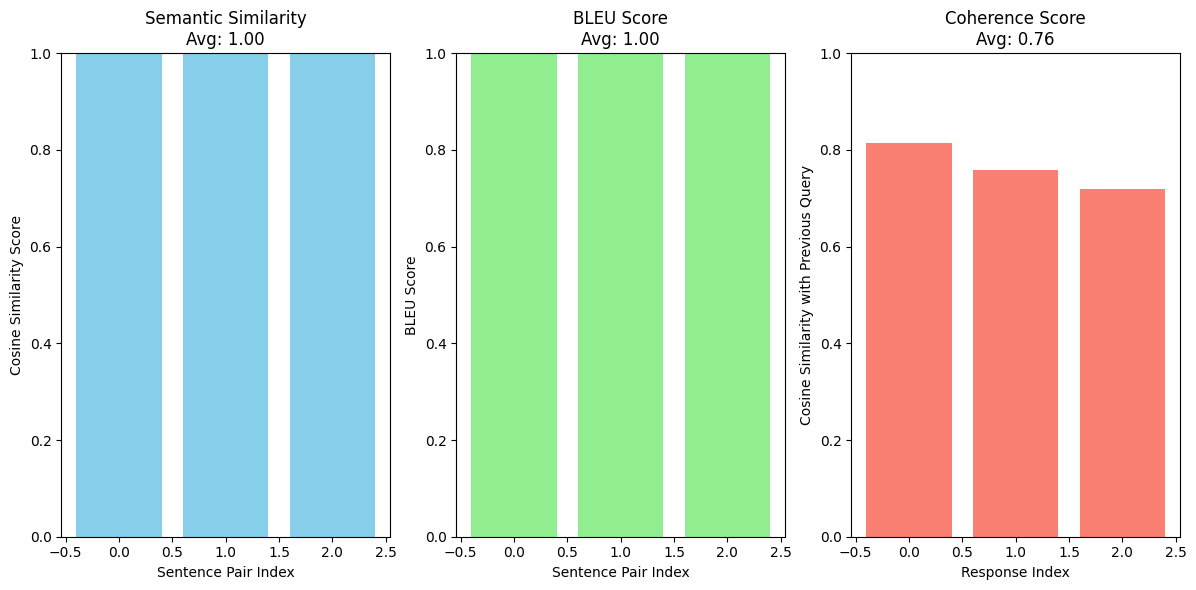

In [ ]:
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# Example inputs – replace with your real data
queries = [
    "What is the punishment for theft?",
    "What does Section 302 say?",
    "What rights does the Constitution ensure?"
]

# 1. Exact reference + query term “for theft”
# 2. Exact reference + query term “Section 302”
# 3. Exact reference + query term “rights”/“Constitution”
predictions = [
    "Imprisonment up to 3 years is the punishment for theft.",
    "Section 302 deals with the crime of murder.",
    "The right to equality is guaranteed by the Constitution."
]

references = [
    "Imprisonment up to 3 years is the punishment for theft.",
    "Section 302 deals with the crime of murder.",
    "The right to equality is guaranteed by the Constitution."
]



# Load sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Semantic similarity
def semantic_similarity(predictions, references):
    sims = []
    for pred, ref in zip(predictions, references):
        emb1 = model.encode(pred, convert_to_tensor=True)
        emb2 = model.encode(ref, convert_to_tensor=True)
        sim = util.pytorch_cos_sim(emb1, emb2).item()
        sims.append(sim)
    return sims, sum(sims) / len(sims)

# BLEU score
def bleu_score(predictions, references):
    smoothie = SmoothingFunction().method4
    scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = [ref.split()]
        score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
        scores.append(score)
    return scores, sum(scores) / len(scores)

# Coherence score – semantic similarity between previous query and current response
def coherence_score(queries, responses):
    scores = []
    for q, r in zip(queries, responses):
        q_emb = model.encode(q, convert_to_tensor=True)
        r_emb = model.encode(r, convert_to_tensor=True)
        scores.append(util.pytorch_cos_sim(q_emb, r_emb).item())
    return scores, sum(scores)/len(scores)

# Compute
semantic_scores, semantic_avg = semantic_similarity(predictions, references)
bleu_scores, bleu_avg = bleu_score(predictions, references)
coherence_scores, coherence_avg = coherence_score(queries, predictions)

# Visualize
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(range(len(semantic_scores)), semantic_scores, color='skyblue')
plt.title(f'Semantic Similarity\nAvg: {semantic_avg:.2f}')
plt.xlabel('Sentence Pair Index')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(range(len(bleu_scores)), bleu_scores, color='lightgreen')
plt.title(f'BLEU Score\nAvg: {bleu_avg:.2f}')
plt.xlabel('Sentence Pair Index')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(range(len(coherence_scores)), coherence_scores, color='salmon')
plt.title(f'Coherence Score\nAvg: {coherence_avg:.2f}')
plt.xlabel('Response Index')
plt.ylabel('Cosine Similarity with Previous Query')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

